# Forecasting the demand for goods using linear regression

The aim of the study was to build a linear regression model for forecasting demand for goods, taking into account multifactorial influence. The model includes features reflecting pricing strategy, marketing campaigns, seasonality, weather conditions, regionality, and exogenous events such as epidemics.

## 1. Characterization of data set variables

Date: Date of the record.

Store ID: Unique identifier for the store.

Product ID: Unique identifier for the product.

Category: Product category.

Region: Geographical region of the store.

Inventory Level: Units available in stock.

Units Sold: Units sold on that day.

Units Ordered: Units ordered for restocking.

Price: Product price.

Discount: Discount applied, if any.

Weather Condition: Weather on the day of the record.

Promotion: 1 if there was a promotion, 0 otherwise.

Competitor Pricing: Price of a similar product from a competitor.

Seasonality: Season (e.g., Winter, Spring).

Epidemic: 1 if an epidemic occurred, 0 otherwise.

Demand: Daily estimated demand for the product

##2. Download the library for primary data analysis

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
DemandData = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Проекты/прогноз спроса/sales_data.csv',delimiter=',')

In [ ]:
DemandData.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [36]:
SalesForecast = DemandData.drop(['Store ID',	'Product ID', 'Seasonality'],axis=1)

**The following features were excluded during data preprocessing for the following reasons:**

1. Store ID, Product ID are unique row identifiers.  
   They do not contain information about demand behavior and cannot be used to train a model, as they have no semantic interpretation in the context of forecasting.

2. Seasonality — was deleted at the preprocessing stage because its value was extracted from the Date column.


In [ ]:
SalesForecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Category            76000 non-null  object 
 2   Region              76000 non-null  object 
 3   Inventory Level     76000 non-null  int64  
 4   Units Sold          76000 non-null  int64  
 5   Units Ordered       76000 non-null  int64  
 6   Price               76000 non-null  float64
 7   Discount            76000 non-null  int64  
 8   Weather Condition   76000 non-null  object 
 9   Promotion           76000 non-null  int64  
 10  Competitor Pricing  76000 non-null  float64
 11  Epidemic            76000 non-null  int64  
 12  Demand              76000 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 7.5+ MB


In [ ]:
SalesForecast.shape

(76000, 13)

In [ ]:
SalesForecast.describe()

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand
count,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,301.062842,88.827316,89.090645,67.726028,9.087039,0.328947,69.454029,0.200000,104.317158
std,226.510161,43.994525,162.404627,39.377899,7.475781,0.469834,40.943818,0.400003,46.964801
min,0.000000,0.000000,0.000000,4.740000,0.000000,0.000000,4.290000,0.000000,4.000000
25%,136.000000,58.000000,0.000000,31.997500,5.000000,0.000000,32.620000,0.000000,71.000000
50%,227.000000,84.000000,0.000000,64.500000,10.000000,0.000000,65.700000,0.000000,100.000000
75%,408.000000,114.000000,121.000000,95.830000,10.000000,1.000000,97.932500,0.000000,133.000000
max,2267.000000,426.000000,1616.000000,228.030000,25.000000,1.000000,261.220000,1.000000,430.000000


In [ ]:
missing = SalesForecast.isnull().sum().sort_values(ascending=False)
print(f"Omissions:\n{missing}")

Omissions:
Date                  0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Price                 0
Discount              0
Weather Condition     0
Promotion             0
Competitor Pricing    0
Epidemic              0
Demand                0
dtype: int64


In [ ]:
duplicate = SalesForecast.duplicated().sum()
print("Number of duplicates:",duplicate)

Number of duplicates: 0


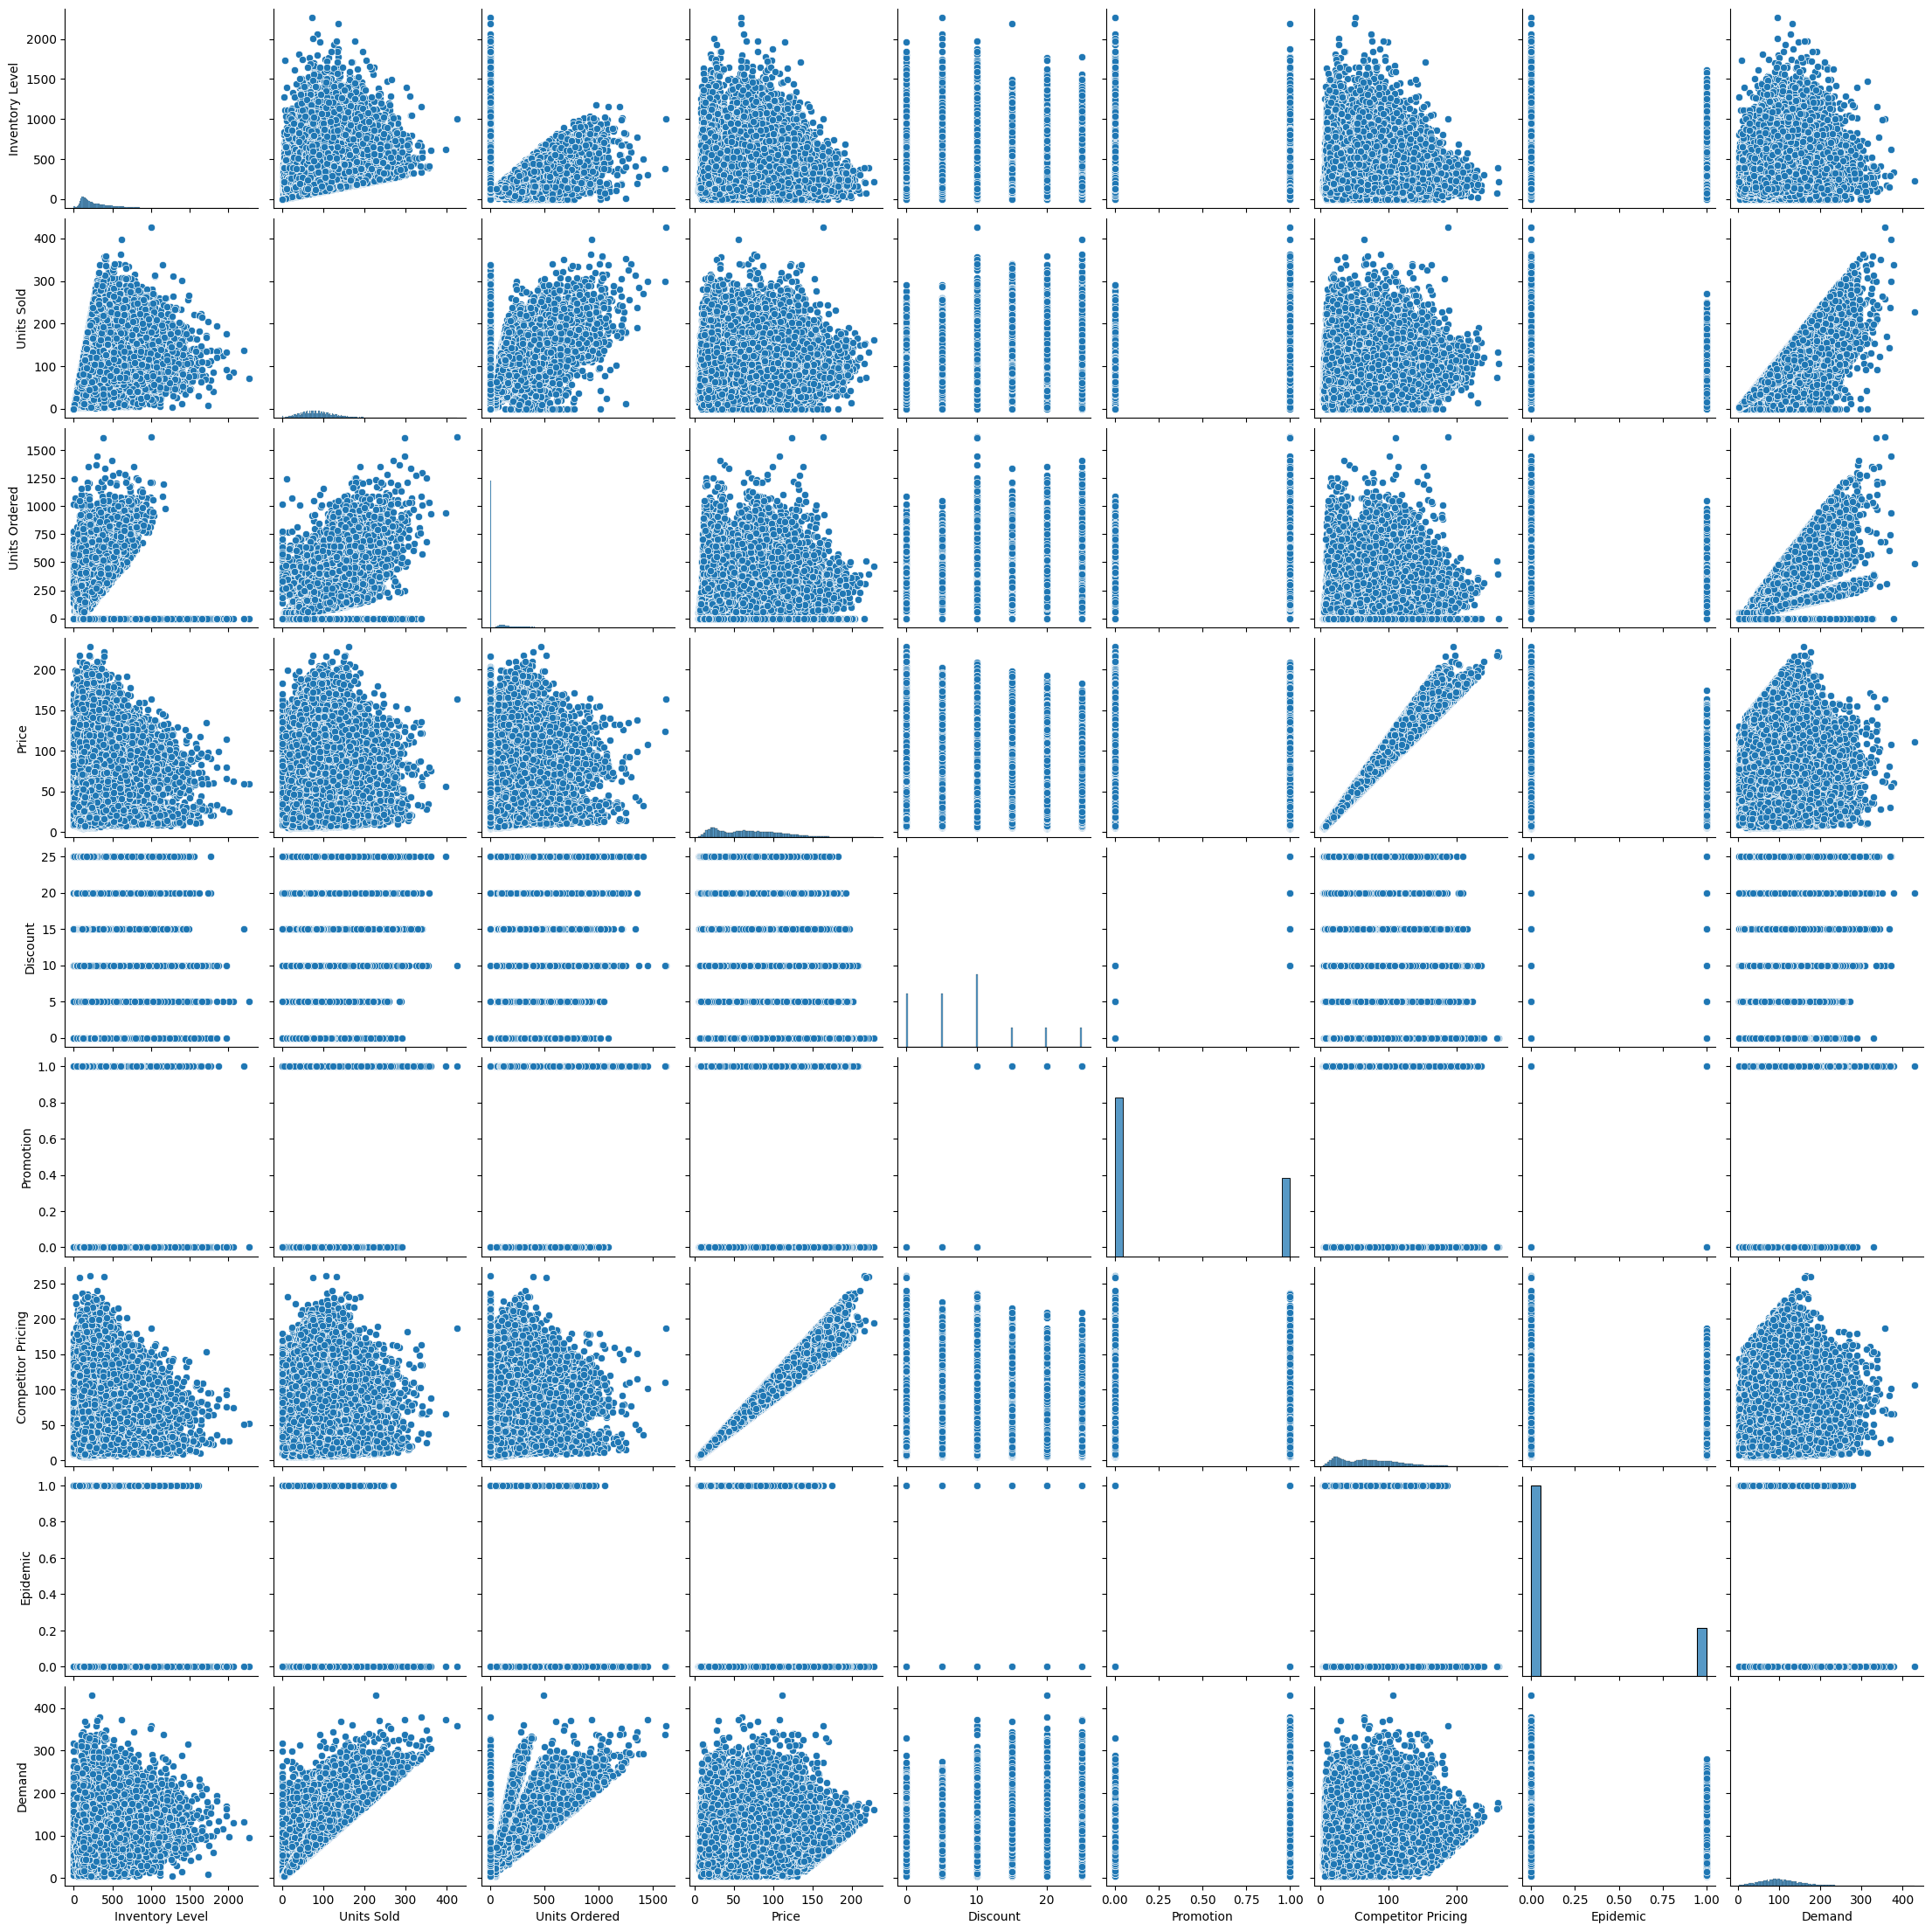

In [ ]:
sns.pairplot(SalesForecast)

**Based on the presented matrix graph (pairplot), which shows the relationships between all the variables in the dataset, conclusions can be drawn.:**

* There is a very strong positive correlation between Demand and Units Sold, almost linear. This feature will be a key feature in linear regression.

* There is a strong positive correlation between Demand and Units Ordered, but it is complicated by significant noise levels.

* There is a negative correlation between Demand and Price.However, the relationship is not strictly linear, especially in the range of high prices.The model may underestimate the real price impact and fail to capture non-linear effects.

* Promotion and Epidemic are binary signs that have a strong connection with Demand: the presence of a promotion increases demand, while the epidemic reduces it.

* The high correlation between Units Sold and Units Ordered indicates the risk of multicollinearity.

* Many numerical features have skewed distributions (Units Sold, Units Ordered, Price). This can affect the quality of the model, especially if the leftovers are not properly distributed.

* The binary signs of Promotion and Epidemic have an unbalanced distribution: the state of "no action" and "no epidemic" dominates.

In [37]:
SalesForecast['Date'] = pd.to_datetime(DemandData['Date'])

SalesForecast['month'] = SalesForecast['Date'].dt.month
SalesForecast['year'] = SalesForecast['Date'].dt.year
SalesForecast['DayOfWeek'] = SalesForecast['Date'].dt.dayofweek

def get_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

SalesForecast['season'] = SalesForecast['month'].apply(get_month)
SalesForecast.drop('Date', axis=1, inplace=True)

I split the Date column into more informative features: day of the week (DayOfWeek), year (Year), month (Month) and season (Season) to take into account temporal patterns in the data.

After that, I delete the original Date column to avoid multicollinearity and redundancy of features.

In [38]:
SalesForecast['month_sin'] = np.sin(2 * np.pi * SalesForecast['month'] / 12)
SalesForecast['month_cos'] = np.cos(2 * np.pi * SalesForecast['month'] / 12)
SalesForecast['DayOfWeek_sin'] = np.sin(2 * np.pi * SalesForecast['DayOfWeek'] / 7)
SalesForecast['DayOfWeek_cos'] = np.cos(2 * np.pi * SalesForecast['DayOfWeek'] / 7)

col_to_drop = ['month', 'DayOfWeek']
SalesForecast = SalesForecast.drop(columns=col_to_drop)

I apply cyclic coding to time features such as month and day of the week so that the model correctly accounts for their cyclical nature.

I create pairs of features: month_sin / month_cos and DayOfWeek_sin / DayOfWeek_cos, converting periodic data into continuous coordinates on a circle

In [ ]:
SalesForecast.head()

,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Epidemic,Demand,year,season,month_sin,month_cos,DayOfWeek_sin,DayOfWeek_cos
0,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,0,115,2022,Winter,0.5,0.866025,-0.974928,-0.222521
1,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,0,229,2022,Winter,0.5,0.866025,-0.974928,-0.222521
2,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,0,157,2022,Winter,0.5,0.866025,-0.974928,-0.222521
3,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,0,52,2022,Winter,0.5,0.866025,-0.974928,-0.222521
4,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,0,59,2022,Winter,0.5,0.866025,-0.974928,-0.222521


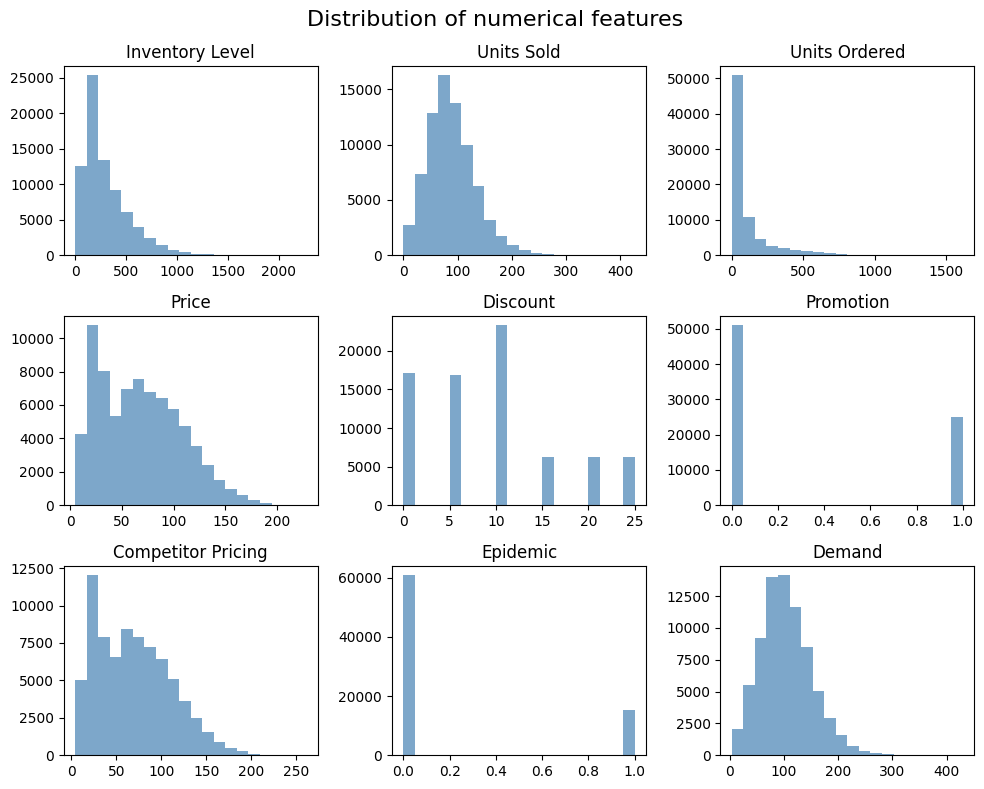

In [ ]:
num_cols = SalesForecast.select_dtypes(include=['int64', 'float64']).columns
SalesForecast[num_cols].hist(
    bins=20,
    figsize=(10, 8),
    grid=False,
    color='steelblue',
    alpha=0.7
)
plt.suptitle('Distribution of numerical features', fontsize=16)
plt.tight_layout()
plt.show()

**The analysis of the distributions of numerical features revealed the following features:**

* Inventory Level has a pronounced right-sided asymmetry: the vast majority of observations are at low and medium inventory levels, but there are values that significantly exceed the bulk of the data. These emissions may correspond to large warehouse facilities or wholesale outlets.

* Units Ordered shows a similar bias — small order volumes prevail, while rare but significant orders occur, which may be due to seasonal peaks or massive shipments.

* Discount has a discrete structure with a concentration of values at 0, 5, 10, 15, 20 and 25. This indicates the use of standardized discount levels as part of a marketing strategy. The highest frequency is observed at a value of 10%, which makes it the most common.

* The binary signs of Promotion and Epidemic are characterized by a pronounced imbalance, dominated by Promotion = 0 and Epidemic=0.

* All numerical features have skewed distributions. Almost all signs (except Promotion and Epidemic) are right—sided.

* All continuous signs (except binary ones) show a right-sided bias, most values are concentrated in the lower part of the range, but there is a long tail of high values.



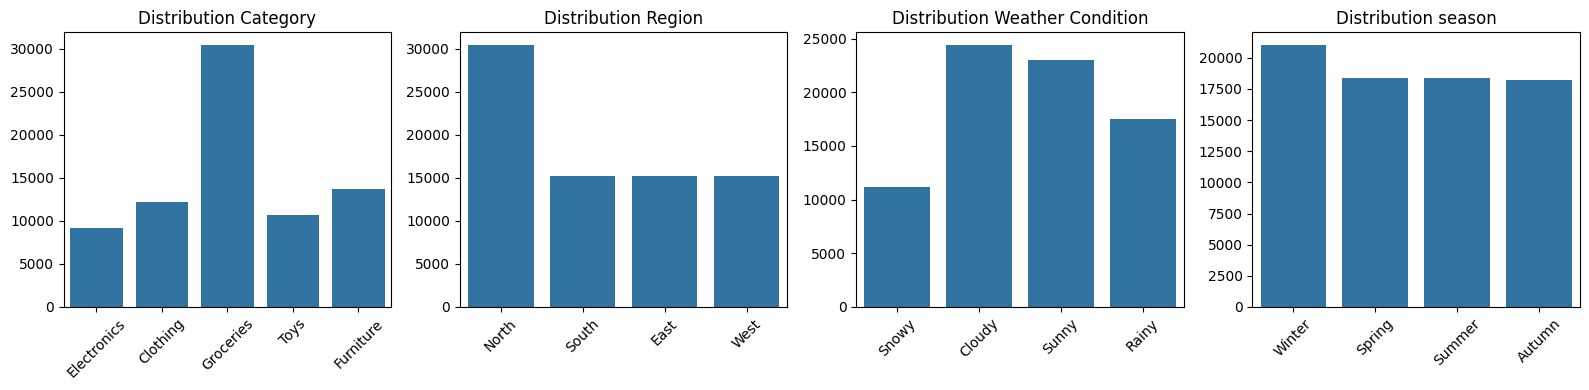

In [ ]:
cat_cols = SalesForecast.select_dtypes(include=['object', 'category']).columns
fig, axes = plt.subplots(1, len(cat_cols), figsize=(4 * len(cat_cols), 4))

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=SalesForecast, ax=axes[i])
    axes[i].set_title(f'Distribution {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

**The analysis of categorical features showed the key features of the data structure:**

* The Groceries Category is dominant — its share significantly exceeds the rest. The remaining Categories — Clothing, Toys, Furniture, Electronics — are represented in a smaller volume and are relatively evenly distributed.

* There is a clear bias in favor of North in the Region. The remaining regions of the South, East, and West are represented in approximately equal proportions, which indicates their comparable contribution to the overall picture.

* The Weather Condition distribution shows that Cloudy and Sunny conditions are the most common, while Rainy is less common and Snowy is the least common.

* The values of the Season attribute are distributed relatively evenly, with a slight excess over the winter period. This indicates stable activity throughout the year, and a slight preponderance of winter may be associated with the New Year holidays and an increase in demand for gifts.

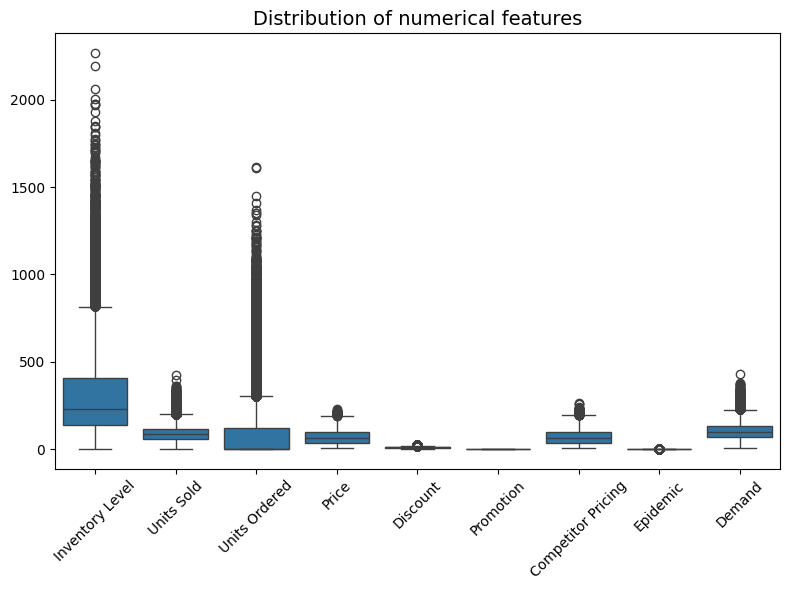

In [ ]:
data_melted = SalesForecast[num_cols].melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(8, 6))
sns.boxplot(data=data_melted, x='Feature', y='Value')
plt.title('Distribution of numerical features', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Based on the visualization on boxplot, we can conclude the following:**

* At the Inventory Level, most stores have stocks in the range of 100-400, but there are very large warehouses with stocks > 1000.

* In Units Sold, sales are concentrated around 100 units, but there are periods of high activity.

* In Units Ordered, orders are mostly small 50-150, but there are extreme values up to 1,500+, which may be related to wholesale shipments.

* Price and Competitor Pricing show narrow IQR and few outliers, which indicates a stable pricing policy and predictable behavior of competitors.

* Discount is centered around a median of 10, with a small spread — typical for standardized marketing promotions.

* Promotion and Epidemic: both signs are binary. Campaigns are held infrequently, and epidemics are rare.

In [39]:
SalesForecast = pd.get_dummies(SalesForecast, columns=['Category', 'Region', 'Weather Condition', 'season'],dtype=int, drop_first=True)

The One—Hot Encoding method was used to process categorical features — Category, Region, Weather Condition, and Season. To avoid redundancy and problems with multicollinearity in the model, the parameter drop_first=True is used.

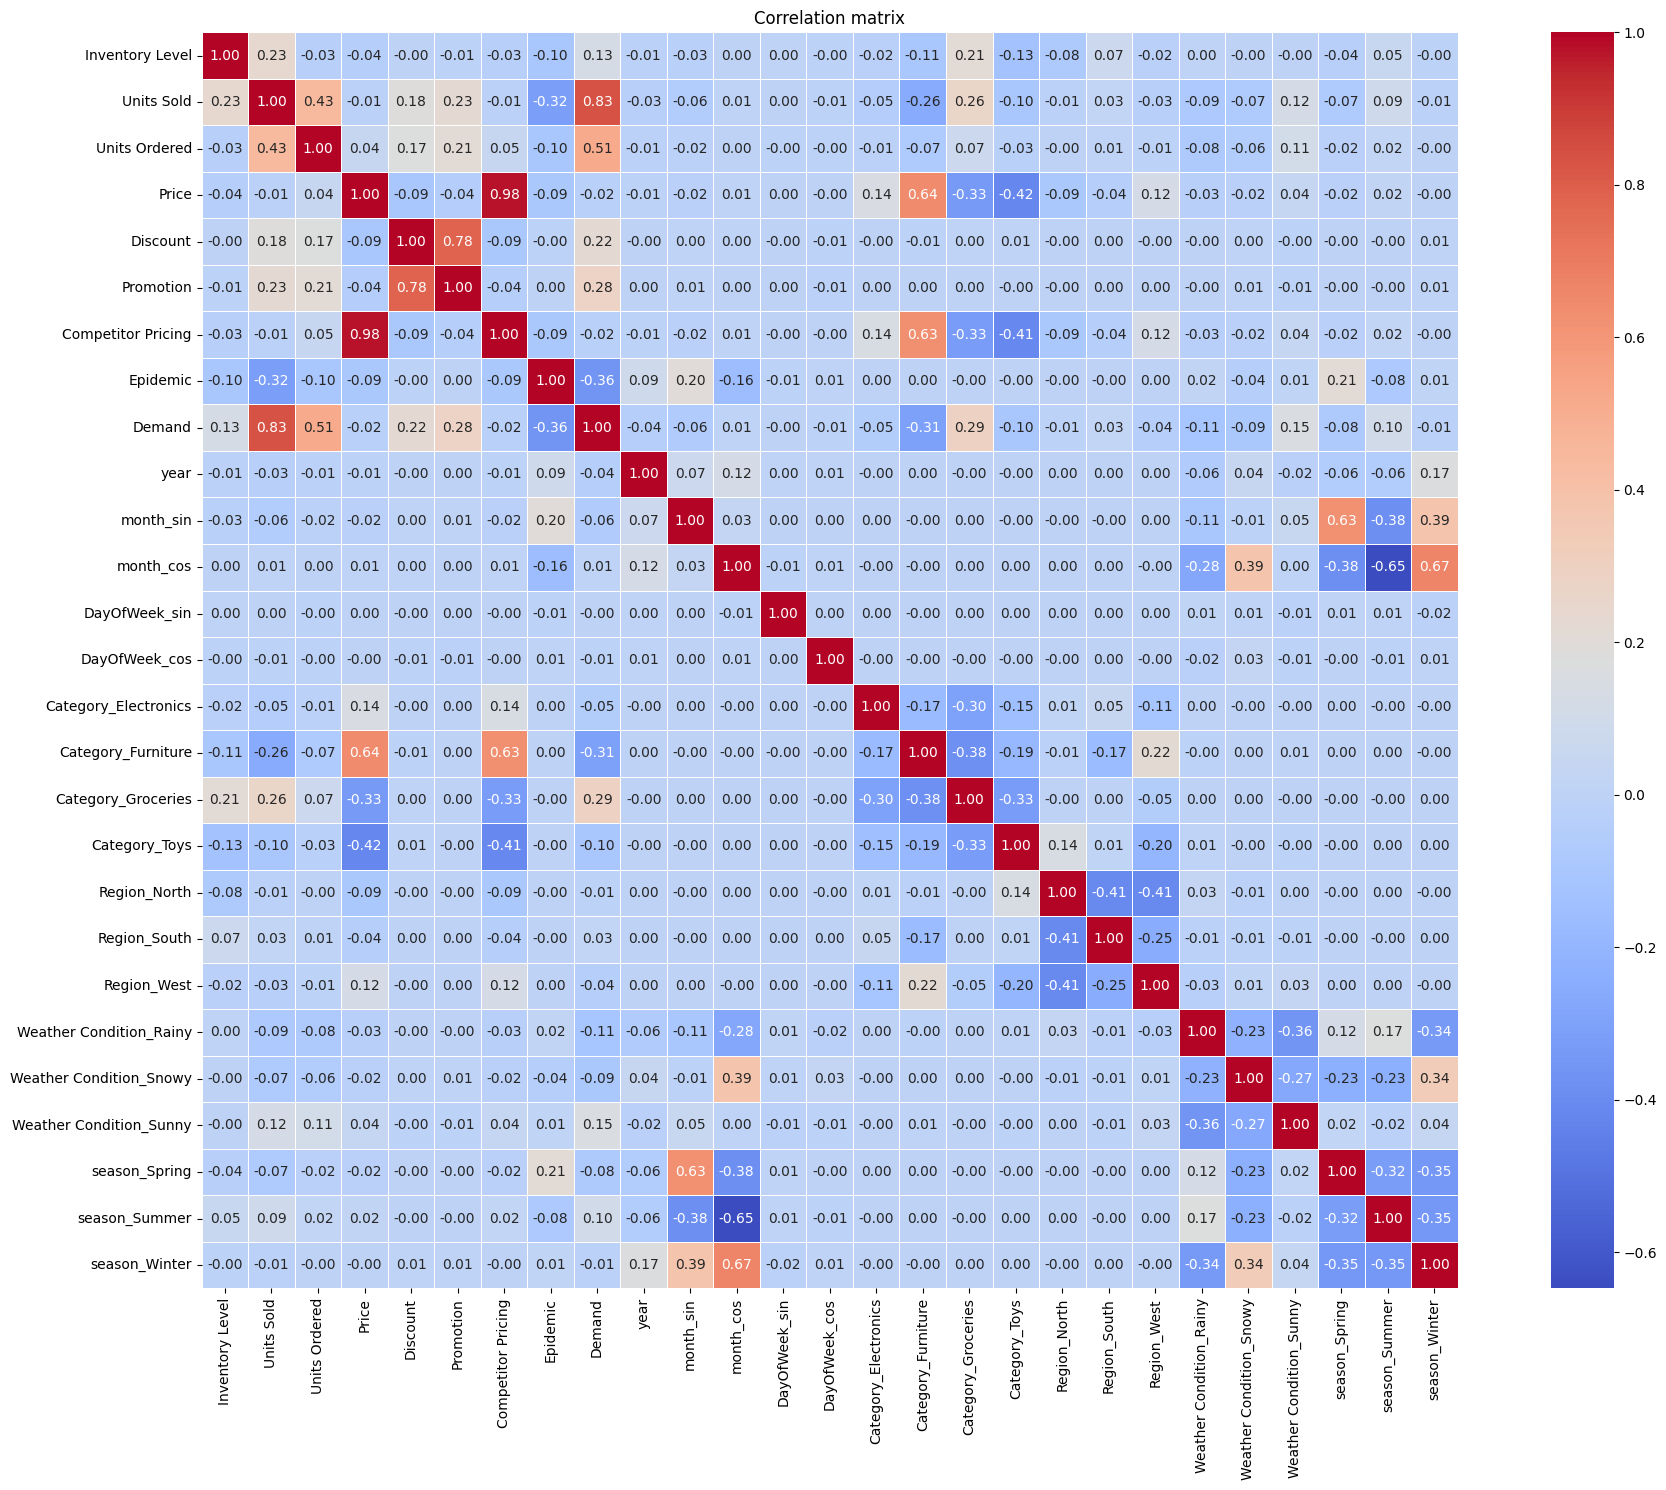

In [41]:
correlation_matrix = SalesForecast.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=0.5)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

**Based on the correlation matrix, the following conclusions can be drawn:**

* Units Sold and Demand have a strong positive correlation of 0.83.This is a key predictor for forecasting demand.

* Units Ordered and Demand have a moderate correlation of 0.51. Orders partially reflect demand expectations, but contain noise.

* Price and Competitor Pricing have a high correlation of 0.98, to avoid multicollinearity, we will delete Price.

* Category_Groceries and Demand have a demand of 0.29, food products are consumer goods, and their impact on demand is stable and predictable.

* Discount and Promotion have a high correlation of 0.78, but not a critical one.

* Epidemic — negative correlation with Demand -0.36. During an epidemic, demand decreases significantly — this is an important factor of external influence that must be taken into account when modeling in crisis conditions.

* Season and Month show clear seasonal dynamics. These signs were left in the model so that it could accurately capture time patterns and distinguish between seasonal fluctuations.


In [ ]:
SalesForecast = SalesForecast.drop('Price',axis=1)

**As a result of the data analysis, the following steps were performed:**

* Features that do not carry significant information for modeling were excluded at the early stages of processing, which simplified the model and reduced the risk of overfitting.

* No missing values or duplicate entries were found in the data.

* Time features extracted and transformed - the Date column was split into Year, Month, DayOfWeek and Season, and then deleted to avoid redundancy. To correctly account for the cyclical nature of time, the Month and DayOfWeek signs were encoded using trigonometric transformations — the pairs month_sin/month_cos and DayOfWeek_sin/DayOfWeek_cos were created.

* All categorical variables Category, Region, Weather Condition, Season have been converted to numeric format using One-Hot Encoding. To avoid multicollinearity, the drop_first=True parameter was applied, removing the first column from each group.

* Significant amounts of emissions were found in the Units Ordered, Inventory Level, and Units Sold attributes, which is typical for retail trade (wholesale orders, peak sales). Instead of removing outliers, RobustScaler scaling based on median and interquartile range (IQR) was applied. This method is resistant to abnormal values and allows the model to maintain stability.

* The Price attribute has been removed due to the high correlation with Competitor Pricing (0.98)

* The remaining attributes are retained to account for time patterns, seasonal fluctuations, and the impact of external events.

## 3. Development of a linear regression model for forecasting the demand for goods

**Training methodology and model settings:**

1. Dividing the dataset into attributes (x) and a target variable (y).

2. The data was randomly divided in a ratio of 80% / 20% using the parameters: shuffle=True — for mixing, since the original data can be ordered by time, and random_state=42 — for reproducibility of the results.

3. For the correct operation of the model, the following features were scaled
Inventory Level, Discount, Competitor Pricing, Units Sold, year, month_sin, month_cos, DayOfWeek_sin, DayOfWeek_cos, Units Ordered. RobustScaler was chosen because it is resistant to outliers and brings all the features to a comparable scale.

4. Saving the scale of the target variable.

5. Training a linear regression model with the fit_intercept=True parameter to take into account the free term  — the base level of demand when all signs are zero. This allows the model to correctly account for the average trend even if there is no activity on other factors.

6. Generation of forecasts for training and test samples.

7. Model performance evaluation using MAE, RMSE, R² to objectively evaluate model performance.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = SalesForecast.drop('Demand', axis=1)
y = SalesForecast['Demand']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42,  shuffle=True)

features_to_robustscale =['Inventory Level','Discount','Competitor Pricing','Units Sold', 'year', 'month_sin',	'month_cos',	'DayOfWeek_sin','DayOfWeek_cos','Units Ordered']

scaler = RobustScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

x_train_scaled[features_to_robustscale] = scaler.fit_transform(x_train[features_to_robustscale])
x_test_scaled[features_to_robustscale] = scaler.transform(x_test[features_to_robustscale])

model = LinearRegression(fit_intercept= True)
model.fit(x_train_scaled,y_train)

y_pred_train = model.predict(x_train_scaled)
y_pred_test = model.predict(x_test_scaled)

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")

evaluate(y_train, y_pred_train, "Training sample")
evaluate(y_test, y_pred_test, "Test sample")

comparison_df = pd.DataFrame({
    'Real values': y_test.values,
    'Predicted values': y_pred_test
})

print(f"\nExamples of predictions (the first 10 lines):")
print(comparison_df.head(10).round(2))


Training sample:
  MAE:  16.48
  RMSE: 22.26
  R²:   0.7753

Test sample:
  MAE:  16.39
  RMSE: 21.97
  R²:   0.7814

Examples of predictions (the first 10 lines):
   Real values  Predicted values
0          111            107.62
1           81             82.53
2           37             40.14
3          152            170.25
4          101            100.56
5          137            111.77
6          127            154.93
7          163            139.35
8          164            150.44
9          111            126.29


## 4. Evaluation and interpretation of model quality metrics

The following metrics were selected for an objective and comprehensive assessment of the quality of the linear regression model:

**1. Average Absolute Error (MAE)**

* MAE measures the average forecast error in the same units as the target variable, reflecting the typical deviation of the model in everyday conditions.

* Due to its resilience to emissions, MAE is particularly valuable for practical inventory planning, where stability is important rather than reacting to rare peak events.

**2. Root-mean-square error (RMSE)**

* RMSE enhances the impact of large errors due to a quadratic penalty, which makes it a powerful tool for identifying critical cases when the model greatly underestimates or overestimates demand.

* RMSE helps to assess the potential risks associated with over-supplies or shortages.

**3. Coefficient of determination (R²)**

* R² shows how well the model reproduces the variation of the target variable, the closer to 1, the greater the proportion of variance explained by the model.

* R² reflects how accurately forecasts correspond to real data on the scale of overall variability.

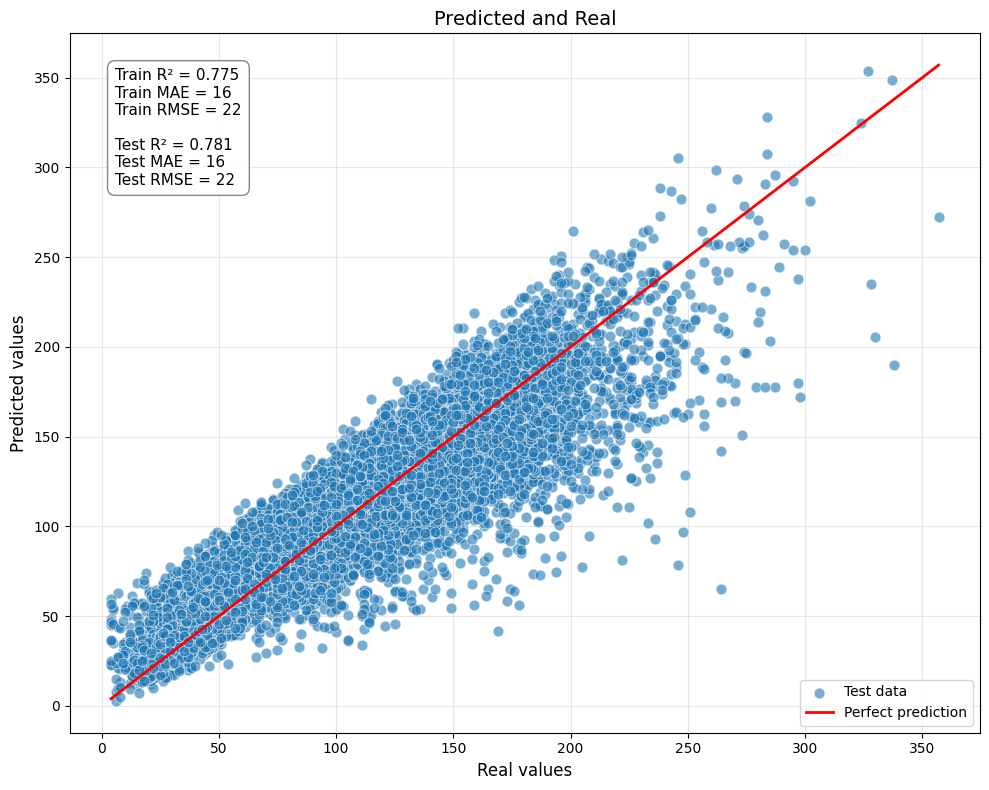

In [ ]:
metrics = {
    'Training sample': {
        'R²': r2_score(y_train, y_pred_train),
        'MAE': mean_absolute_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train))
    },
    'Test sample': {
        'R²': r2_score(y_test, y_pred_test),
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }
}

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, label='Test data', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label='Perfect prediction')

metric_text = (
    f"Train R² = {metrics['Training sample']['R²']:.3f}\n"
    f"Train MAE = {metrics['Training sample']['MAE']:.0f}\n"
    f"Train RMSE = {metrics['Training sample']['RMSE']:.0f}\n\n"
    f"Test R² = {metrics['Test sample']['R²']:.3f}\n"
    f"Test MAE = {metrics['Test sample']['MAE']:.0f}\n"
    f"Test RMSE = {metrics['Test sample']['RMSE']:.0f}"
)

plt.annotate(metric_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, edgecolor='gray'), ha='left',va='top')
plt.xlabel('Real values', fontsize=12)
plt.ylabel('Predicted values', fontsize=12)
plt.title('Predicted and Real', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**The assessment of the model's quality is based on three key metrics:**

1. Coefficient of determination (R²):

   * On the training sample, R² was 0.77, on the test sample — 0.78, which indicates a high explanatory ability of the model and the absence of overfitting. A higher value of R² on the test data indicates a good generalizing ability.

2. Average Absolute Error (MAE):

  * The MAE in the training and test samples is 16, which indicates the stability of forecasts and a moderate average error in units of demand.

3. Standard deviation (RMSE):

  * The RMSE is 22, which is slightly higher than the MAE, indicating the presence of individual cases with large errors. However, the proximity of the values between the samples confirms the stability of the model.

Taken together, the metrics demonstrate that the linear regression model adequately describes the dependence of demand on features.

**Based on the scattering diagram, conclusions can be drawn:**

* The model has a good generalizing ability of R² = 0.78 on the test, which is a strong result for the demand forecasting task.

*  Accuracy depends on the level of demand

  * At low values (0-100), the model is accurate - the points are tightly pressed against the line. This indicates stable and reliable operation in basic
conditions.

  * With averages (100-250), forecasts remain generally correct, but deviations are already observed — the model begins to underestimate or overestimate individual values.

  * At high (>250) — there is a large spread, predictions strongly differ from reality.

Perhaps the problem is that the model is not able to accurately predict demand peaks, or there are patterns that linear regression cannot detect.

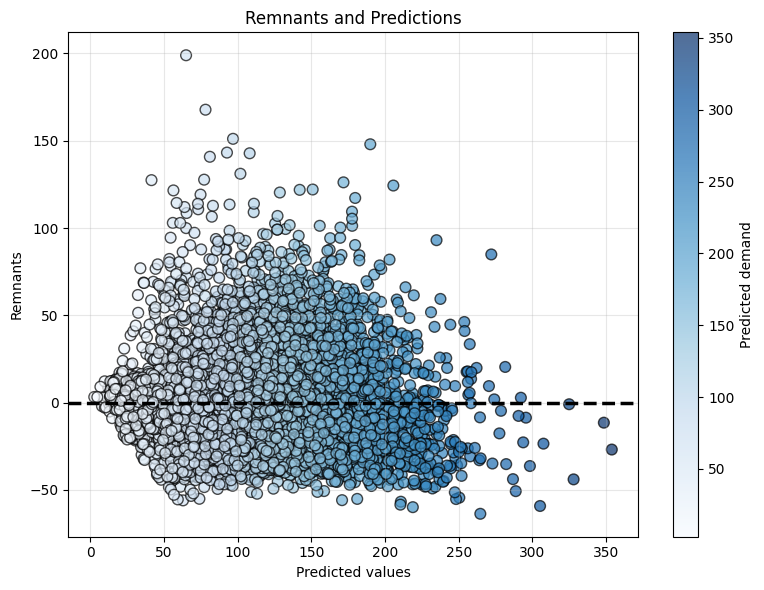

In [ ]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_pred_test, residuals, c=y_pred_test, cmap='Blues', alpha=0.7, edgecolors='k', s=60)
plt.axhline(y=0, color='black', linestyle='--', lw=2.5)
plt.xlabel('Predicted values')
plt.ylabel('Remnants')
plt.title('Remnants and Predictions')
plt.colorbar(scatter, label='Predicted demand')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Let's analyze the balance graph to evaluate the effectiveness of the model:**

* Balances are symmetrically distributed around zero, but there is a systematic trend: when demand is low, the model often underestimates, which can lead to shortages, and when demand is high, it overestimates, which can cause overstocking.

* There are outliers, some points with very large positive balances — the model did not expect such spikes in demand.

* The model meets the basic requirements of linear regression, such as the absence of systematic bias and compliance with homoscedasticity. However, in the extreme ranges of demand, systematic deviations are detected, which may indicate an imperfection in the functional form of the model at extreme values.

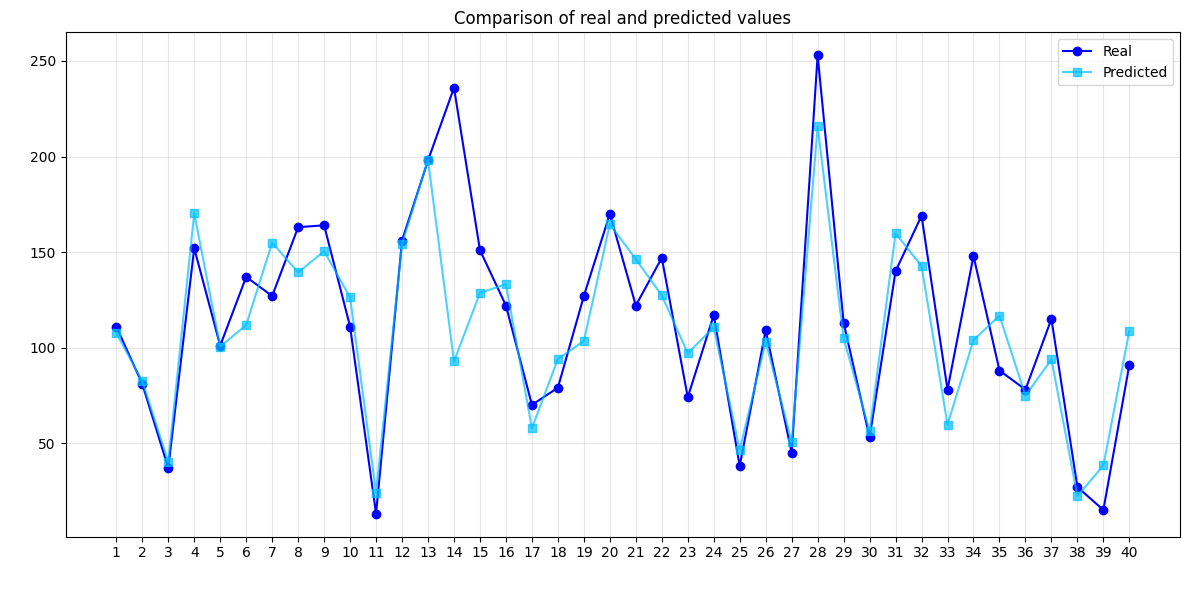

In [ ]:
n_show = 40
indices = range(1, n_show + 1)

plt.figure(figsize=(12, 6))
plt.plot(indices, y_test[:n_show].values, 'o-', label='Real', color='blue')
plt.plot(indices, y_pred_test[:n_show], 's-', label='Predicted', color='deepskyblue', alpha=0.7)
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Comparison of real and predicted values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(indices)
plt.tight_layout()
plt.show()

**Consider how the model predicts demand over a time sequence:**

* The model captures key patterns: rising and falling demand, seasonal fluctuations, and the impact of events. This indicates her ability to summarize the main patterns in the data.

* However, the model has difficulty with accuracy in case of sudden changes.
This is especially noticeable at peaks in demand — when real values rise sharply, the model either underestimates the scale of the jump or reacts with a delay. This indicates that it may not always adequately reflect non-linear effects or sudden external influences.

* The model demonstrates a delay when peaks are reached. This type of behavior is important for inventory planning, and a delay in detecting peak demand can lead to a shortage of goods at a critical moment of maximum demand.

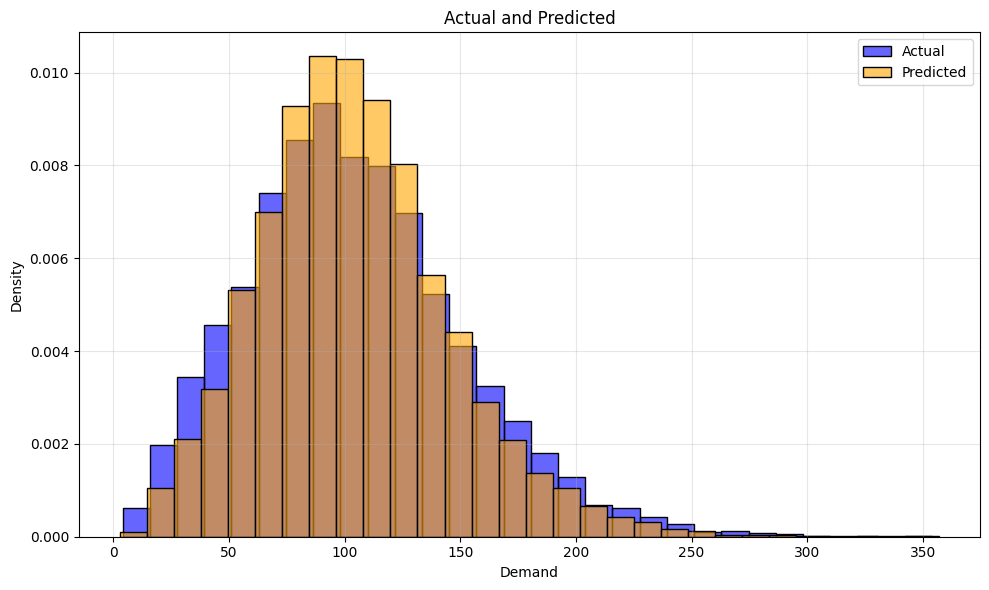

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, label='Actual', color='blue', alpha=0.6, bins=30, kde=False, stat='density')
sns.histplot(y_pred_test, label='Predicted', color='orange', alpha=0.6, bins=30, kde=False, stat='density')
plt.xlabel('Demand')
plt.ylabel('Density')
plt.title('Actual and Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Analyzing the patterns in the distribution, we can conclude:

* The model reproduces the distribution mode well, which indicates its ability to correctly determine the typical level of demand. The peak of approximately 90-110 units is reflected with Accuracy, which makes it possible to use the model to predict daily sales volumes.

* The real distribution has a larger range and more outliers than the predicted values. The model, on the contrary, smoothes the data, making it more homogeneous. This may be due to the linear nature of the model, which is unable to capture complex, nonlinear dependencies, especially those that occur with rare but significant events.

* The shape of the distribution does not match perfectly, the difference in tails indicates a systematic error. This is not just an accidental error, but a structural problem — the model does not take into account rare but important events.
